# Capstone — Mini Real Estate Analytics Warehouse

Design schema, load synthetic data, profile, clean, and analyze. Visualize with seaborn.


## Environment Setup

In [7]:
import sys, sqlite3, pandas as pd, numpy as np, matplotlib.pyplot as plt
print(sys.version)
import seaborn as sns
sns.set_theme()
from pathlib import Path
DB_PATH = Path('course.db')
conn = sqlite3.connect(DB_PATH)
conn.execute('PRAGMA foreign_keys=ON;')
print('SQLite ready at', DB_PATH.resolve())

3.11.9 (v3.11.9:de54cf5be3, Apr  2 2024, 07:12:50) [Clang 13.0.0 (clang-1300.0.29.30)]
SQLite ready at /Users/subhasht/Desktop/VSCode Programs/GenAI_Curriculum/Phase1/Data_Engineering/course.db


In [8]:
def run_sql(q, params=None):
    params = params or {}
    df = pd.read_sql_query(q, conn, params=params)
    display(df)
    return df

## 1. Problem Statement
Build a mini warehouse for real estate analytics to answer:
- Crerate few tables locations, agents,homes, sales
- Insert sample data
- Perform Data Cleaning and Profiling
- Average price by city/state
- Top agents by total sales
- Trend of sales by month

In [9]:
# Schema
conn.executescript('''
DROP TABLE IF EXISTS locations;
DROP TABLE IF EXISTS agents;
DROP TABLE IF EXISTS homes;
DROP TABLE IF EXISTS sales;
CREATE TABLE locations(
  location_id INTEGER PRIMARY KEY,
  city TEXT NOT NULL,
  state TEXT NOT NULL
);
CREATE TABLE agents(
  agent_id INTEGER PRIMARY KEY,
  name TEXT NOT NULL
);
CREATE TABLE homes(
  home_id INTEGER PRIMARY KEY,
  location_id INTEGER NOT NULL,
  bedrooms INTEGER NOT NULL,
  bathrooms REAL NOT NULL,
  sqft INTEGER NOT NULL,
  home_type TEXT NOT NULL,
  year_built INTEGER,
  FOREIGN KEY(location_id) REFERENCES locations(location_id)
);
CREATE TABLE sales(
  sale_id INTEGER PRIMARY KEY,
  home_id INTEGER NOT NULL,
  agent_id INTEGER NOT NULL,
  sale_date TEXT NOT NULL,
  sale_price REAL NOT NULL CHECK(sale_price>=0),
  FOREIGN KEY(home_id) REFERENCES homes(home_id),
  FOREIGN KEY(agent_id) REFERENCES agents(agent_id)
);
'''); conn.commit()
print("Capstone schema ready.")

IntegrityError: FOREIGN KEY constraint failed

## 2. Seed Synthetic Data

In [ ]:
conn.executescript('''
INSERT INTO locations(city,state) VALUES
 ('Austin','TX'),('Boston','MA'),('Chicago','IL'),('Denver','CO'),('Dallas','TX');
INSERT INTO agents(name) VALUES ('Alex Kim'),('Priya Singh'),('Carlos M.'),('J. Rivera');
INSERT INTO homes(location_id,bedrooms,bathrooms,sqft,home_type,year_built) VALUES
 (1,3,2.0,1600,'SingleFamily',2002),
 (1,4,2.5,2200,'SingleFamily',2010),
 (2,2,1.0,900,'Condo',1995),
 (3,3,2.0,1400,'Townhome',2008),
 (4,5,3.0,2800,'SingleFamily',2018),
 (5,3,2.0,1500,'SingleFamily',2005);
INSERT INTO sales(home_id,agent_id,sale_date,sale_price) VALUES
 (1,1,'2024-05-11',420000),
 (2,2,'2024-06-20',630000),
 (3,2,'2024-03-03',390000),
 (4,3,'2024-09-01',415000),
 (5,1,'2024-02-14',780000),
 (6,4,'2024-08-21',455000);
'''); conn.commit()
print("Seeded synthetic data.")

Seeded synthetic data.


## 3. Profiling & Cleaning

,n_sales,min_price,max_price
0,6,390000.0,780000.0


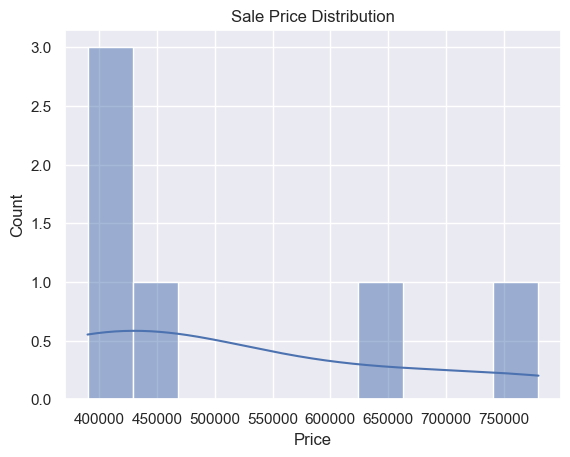

In [ ]:
run_sql("SELECT COUNT(*) AS n_sales, MIN(sale_price) AS min_price, MAX(sale_price) AS max_price FROM sales;")
sns.histplot(pd.read_sql_query("SELECT sale_price FROM sales", conn)['sale_price'], bins=10, kde=True)
plt.title("Sale Price Distribution"); plt.xlabel("Price"); plt.ylabel("Count"); plt.show()
# Example cleanup: unify full state names to abbreviations if present
conn.execute("UPDATE locations SET state='TX' WHERE state LIKE 'Texas';"); conn.commit()

## 4. Analytics Queries + Visuals

,city,avg_price
0,Denver,780000.0
1,Austin,525000.0
2,Dallas,455000.0
3,Chicago,415000.0
4,Boston,390000.0


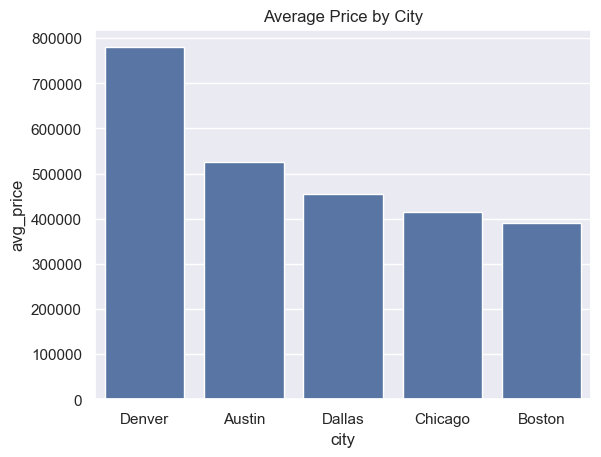

,name,total_sales
0,Alex Kim,1200000.0
1,Priya Singh,1020000.0
2,J. Rivera,455000.0
3,Carlos M.,415000.0


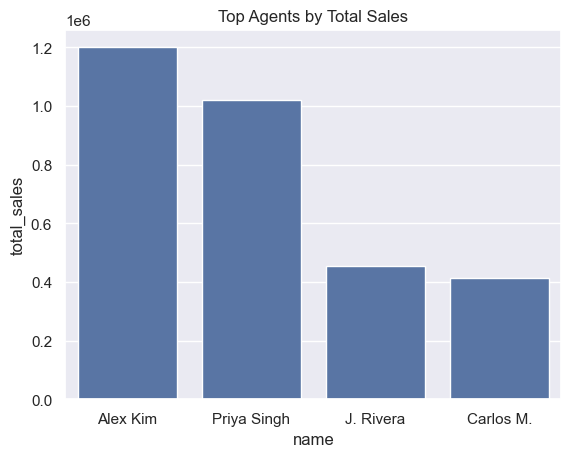

In [ ]:
avg_price = run_sql('''
SELECT l.city, ROUND(AVG(s.sale_price),2) AS avg_price
FROM sales s
JOIN homes h ON s.home_id=h.home_id
JOIN locations l ON h.location_id=l.location_id
GROUP BY l.city ORDER BY avg_price DESC;
''')
sns.barplot(data=avg_price, x="city", y="avg_price"); plt.title("Average Price by City"); plt.show()

top_agents = run_sql('''
SELECT a.name, ROUND(SUM(s.sale_price),2) AS total_sales
FROM sales s JOIN agents a ON s.agent_id=a.agent_id
GROUP BY a.name ORDER BY total_sales DESC;
''')
sns.barplot(data=top_agents, x="name", y="total_sales"); plt.title("Top Agents by Total Sales"); plt.show()